# Sentinel-2 Vegetation Phenology
This notebook calculates vegetation phenology changes using Sentinel-2 data. To detect changes, the algorithm uses Normalized Difference Vegetation Index (NDVI) which is a common proxy for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  

## Load Data Cube Configuration and Import Utilities

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube()

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

import xarray as xr
import numpy as np  
import matplotlib.pyplot as plt

In [2]:
# Select a Product and Platform
product = "s2_google"
platform = "Sentinel-2A"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [3]:
# NEW Yield Data from Vietnam (18-Nov-2022)

# lat_long = (10.443492, 105.281103) # 17, Chau Thanh, Yield High
# lat_long = (10.4172, 105.3635) # 28, Chau Thanh, Low High

# lat_long = (10.454342, 105.322838) #6, Chau Thanh, High Yield
# lat_long = (10.434116, 105.273150) #13, Chau Thanh, Low Yield
# lat_long = (10.392899, 105.188514) #37, Chau Thanh, High Yield
# lat_long = (10.394341, 105.126836) #47, Chau Thanh, Low Yield
# lat_long = (10.356519, 105.309450) #146, Chau Thanh, High Yield
lat_long = (10.354744, 105.336739) #142, Chau Thanh, Low Yield

box_size_deg = 0.0004 # Typically yields 5x5 pixel region

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Define Time Range 
# The format of the time date is YYYY-MM-DD
start_date = '2022-04-01'
end_date = '2022-09-01'
time_extents = (start_date,end_date)

In [4]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load bands needed for NDVI and remove clouds and water

In [5]:
sentinel_dataset = dc.load(latitude = latitude,
                           longitude = longitude,
                           platform = platform,
                           time = time_extents,
                           product = product,
                           group_by = 'solar_day',
                           measurements = ['red', 'nir', 'scl'])

In [6]:
# Filter data using SCL band classification

# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water
# scl=8 > Cloud Medium Probability
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud

cloud_mask = (sentinel_dataset.scl != 0) & (sentinel_dataset.scl != 1) & \
             (sentinel_dataset.scl != 3) & (sentinel_dataset.scl != 8) & \
             (sentinel_dataset.scl != 9) & (sentinel_dataset.scl != 10)

land_mask =  ((sentinel_dataset.scl != 6) & cloud_mask)

# Drop the SCL data as it is no longer needed
sentinel_dataset = sentinel_dataset.drop('scl')

# Apply land mask ... NO Clouds, NO Cloud Shadows and NO Water pixels
cleaned_dataset = sentinel_dataset.where(land_mask)

## Define NDVI and add it to the dataset

In [7]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [8]:
sentinel_dataset['NDVI'] = NDVI(sentinel_dataset)

In [9]:
cleaned_dataset['NDVI'] = NDVI(cleaned_dataset)

In [10]:
cleaned_dataset

<xarray.Dataset>
Dimensions:      (latitude: 6, longitude: 5, time: 29)
Coordinates:
  * time         (time) datetime64[ns] 2022-04-05T03:35:16.797000 ... 2022-08...
  * latitude     (latitude) float64 10.35 10.35 10.35 10.35 10.35 10.35
  * longitude    (longitude) float64 105.3 105.3 105.3 105.3 105.3
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) float64 1.948e+03 1.892e+03 ... nan
    nir          (time, latitude, longitude) float64 2.388e+03 2.38e+03 ... nan
    NDVI         (time, latitude, longitude) float64 0.1015 0.1142 ... nan nan
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [11]:
# Plot the monthly time slice data in a table
import pandas as pd
pd.DataFrame({'time': cleaned_dataset.time.values})

,time
0,2022-04-05 03:35:16.797
1,2022-04-10 03:35:12.251
2,2022-04-15 03:35:18.637
3,2022-04-20 03:35:10.799
4,2022-04-25 03:35:20.466
5,2022-04-30 03:35:08.856
6,2022-05-10 03:35:12.796
7,2022-05-15 03:35:19.893
8,2022-05-20 03:35:15.347
9,2022-05-25 03:35:22.688


## Plot NDVI vs Time

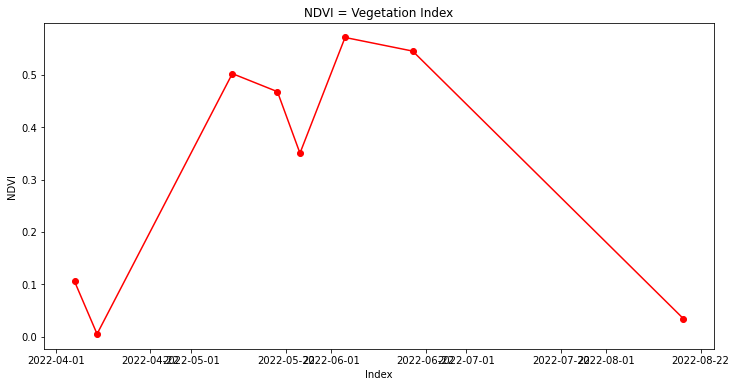

In [12]:
nanmask = np.any(np.isfinite(cleaned_dataset.NDVI), axis=(1,2))
 
plt.figure(figsize=(12, 6))
plt.plot(cleaned_dataset.time[nanmask],
         cleaned_dataset['NDVI'][nanmask].median(dim=['longitude','latitude']),
         color='red',marker='o')
plt.xlabel("Index")
plt.ylabel("NDVI")
plt.title("NDVI = Vegetation Index");

In [13]:
# Output data to CSV
filename = "output/Thanh_LY142.csv"
img3 = cleaned_dataset['NDVI']
img5 = img3.median(dim=['longitude','latitude'])
img5.to_dataframe().to_csv(filename)